## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

#### 1. Read in the data.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('chronic_kidney_disease_full.csv')

In [3]:
data.head(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.01,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd


In [4]:
data.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

#### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer: rbc, rc, age. Study mentions blood levels being indicators of CKD. Also bone density, but I'm not sure how any of those other features relate to that.

---

## Step 3: Explore the data.

#### 3. How much of the data is missing from each column?

In [5]:
data.isna().sum()/data.shape[0] # % of missing data in each column

age      0.0225
bp       0.0300
sg       0.1175
al       0.1150
su       0.1225
rbc      0.3800
pc       0.1625
pcc      0.0100
ba       0.0100
bgr      0.1100
bu       0.0475
sc       0.0425
sod      0.2175
pot      0.2200
hemo     0.1300
pcv      0.1775
wbcc     0.2650
rbcc     0.3275
htn      0.0050
dm       0.0050
cad      0.0050
appet    0.0025
pe       0.0025
ane      0.0025
class    0.0000
dtype: float64

#### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

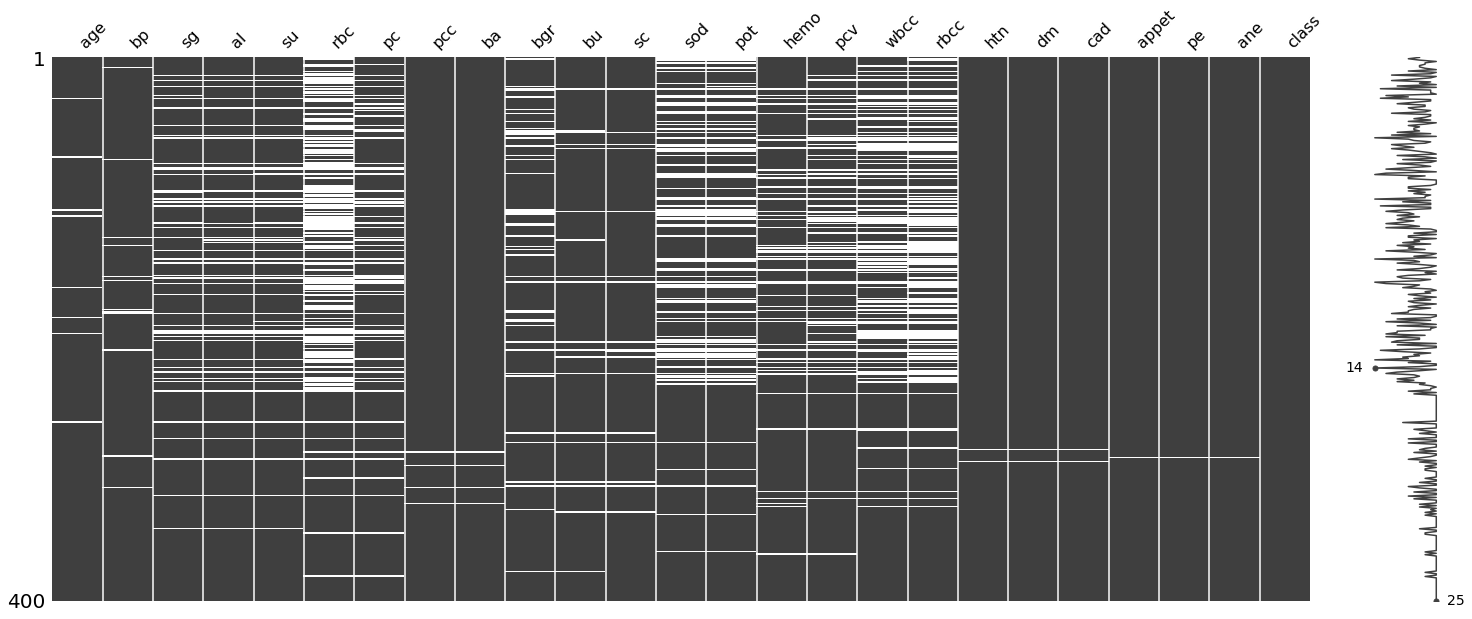

In [6]:
import missingno as mn
import matplotlib.pyplot as plt
mn.matrix(data)
plt.show()

In [7]:
data.dropna().shape[0] / data.shape[0]

0.395

Answer: If we only examined complete cases, we would only be fitting our models on 40% of the available observations. Might be best to impute some of the missing data. Especially since a lot of the missing values are spaced out.

#### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer: 
1) Data was compiled from 6 different hospitals. Each hospital could have different resources or standard practices that affected the consistency of our data set. 
2) We're also looking at a really small sample size of data. It is possible a sample of 400 oberservations will be unrepresentative of the population at large. 
3) Our data is imbalanced with 2/3 of the observations being diagnosed with CKD. It would be ideal to have a larget sample of notckd.

---

## Step 4: Model the data.

#### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

In [8]:
data['class'].value_counts()

ckd       250
notckd    150
Name: class, dtype: int64

Answer: A null model will tell every patient they have CKD.

#### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: In problem 6 we optimized for sensitivity: 250 (true positives) / (250 true positives + 0 false negatives) = 100%

#### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer: The model will tell 150 people that do not have CKD that they have an illness. Those patients might then receive unnecessary treatments.

#### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer: You can take the inverse of the null model and tell everybody they do not have CKD.

#### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: In problem 9 we optimized for specificity 150 (true negatives) / (150 (true negatives) + 0 (false positives)) = 100%

#### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: None of the patients will be informed they have an illness because the results return all the false negatives.

#### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

Remember to do a train/test split. We suggest using GridSearchCV and pipelines.

In [9]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, make_scorer
from sklearn.impute import SimpleImputer

In [10]:
data.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


In [11]:
si = SimpleImputer(strategy='most_frequent')

In [12]:
data[['rbc', 'pc', 'pcc', 'ba']] = si.fit_transform(data[['rbc', 'pc', 'pcc', 'ba']])

In [13]:
ohe_bi = OneHotEncoder(drop='if_binary', sparse=False)

In [14]:
# binarize data
data[['rbc', 'pc', 'pcc', 'ba', 'class']] = ohe_bi.fit_transform(data[['rbc', 'pc', 'pcc', 'ba', 'class']])

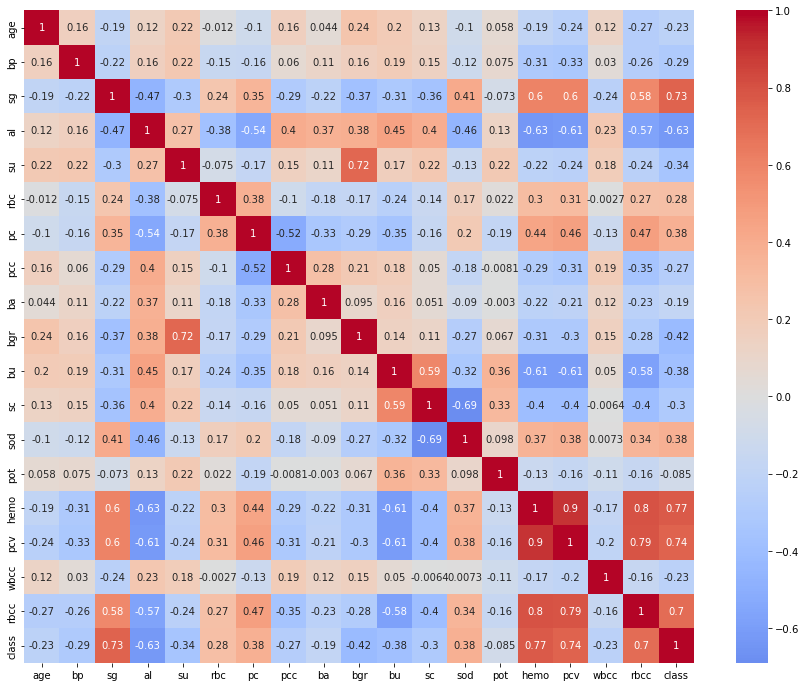

In [15]:
plt.figure(figsize=(15, 12))
sns.heatmap(data.corr(), cmap='coolwarm', annot=True, center=0);

In [16]:
features1 = ['sg', 'al', 'hemo', 'pcv', 'rbcc']                             # take featurs with a corr above or below .5/-.5
features2 = ['sg', 'al', 'pc', 'bgr', 'bu', 'sod', 'hemo', 'pcv', 'rbcc']   # grab features with a corr above or below .35/-.35

lr = LogisticRegression(max_iter=10_000)
params = {'C': [.01, .1, 1, 10, 100]}
gs = GridSearchCV(lr, params, n_jobs=-1, scoring=make_scorer(recall_score))

In [17]:
si.fit(data[features1])
data[features1] = si.transform(data[features1])

In [18]:
data[features1].isna().sum()

sg      0
al      0
hemo    0
pcv     0
rbcc    0
dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data[features1], data['class'], stratify=data['class'], random_state=100)

In [20]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100]},
             scoring=make_scorer(recall_score))

In [21]:
pd.DataFrame(gs.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.026026,0.003365,0.005496,0.001384,0.01,{'C': 0.01},0.913043,0.956522,0.782609,0.681818,0.863636,0.839526,0.097760,5
1,0.033741,0.004083,0.004989,0.000253,0.1,{'C': 0.1},1.000000,0.913043,0.826087,0.772727,0.909091,0.884190,0.078313,4
2,0.043020,0.004815,0.004559,0.000497,1,{'C': 1},1.000000,0.956522,0.869565,0.909091,0.909091,0.928854,0.044997,1
3,0.042909,0.007255,0.004818,0.001322,10,{'C': 10},1.000000,0.956522,0.869565,0.909091,0.909091,0.928854,0.044997,1
4,0.043365,0.005438,0.004403,0.001724,100,{'C': 100},1.000000,0.956522,0.869565,0.909091,0.909091,0.928854,0.044997,1


In [22]:
y_pred = gs.predict(X_test)

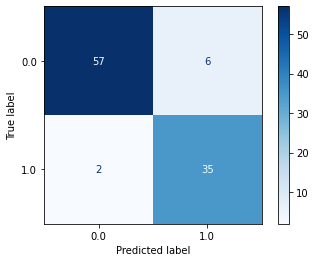

Accuracy: 0.92
Bal Acc: 0.9253539253539254
Precision: 0.8536585365853658
Recall: 0.9459459459459459
F1 Score: 0.8974358974358975


In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues');
plt.show() 
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Bal Acc: {balanced_accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')


---

## Step 5: Evaluate the model.

#### 13. How well does your model perform in terms of accuracy?

In [24]:
y_test.value_counts(normalize=True)

0.0    0.63
1.0    0.37
Name: class, dtype: float64

Answer: The logistic regression model performs roughly 30% more accurately than our baseline model. Pretty good!

#### 14. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

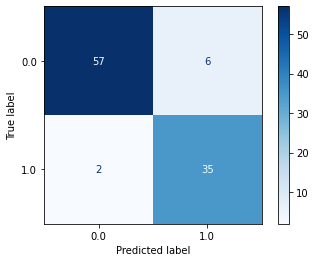

Accuracy: 0.92
Bal Acc: 0.9253539253539254
Precision: 0.8536585365853658
Recall: 0.9459459459459459
F1 Score: 0.8974358974358975


In [25]:
# it makes the most sense to generate a CM on our test data. They are our predictions, after all
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues');
plt.show() 
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Bal Acc: {balanced_accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

#### 15. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: We definitely want to minimize false negatives, so recall/sensitivity should be the most important. tp / (tp + fn). As such, we scored the grid search cv on recall.

#### 16. How does your model perform for your chosen metric?

Answer:

In [26]:
# Our model performs the best on recall over all other metrics

#### 17. Plot the ROC Curve.

In [27]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

In [28]:
roc_auc_score(y_test, gs.predict_proba(X_test)[:,1])    # all the rows and just the "yes"

0.993993993993994

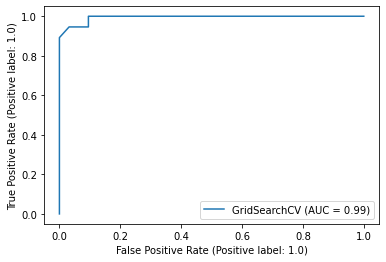

In [29]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

#### 18. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

In [30]:
# Logistic regression outputs a 1 or a 0. A 'yes' or a 'no.' This makes it very handy for classification problems. Training times are fast and the 
# results are typically accurate across the spectrum of the prediction. It performs better than most algos on smaller data sets. The disadvantage is log reg
# assumes a linear relationship and not all classification problems are linear.

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!

We'll leave that for another day!